# **Fraudulent Card Transaction**

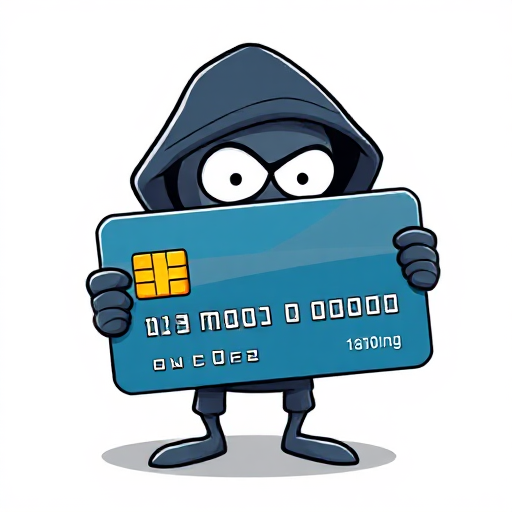

In this project, I built classification models to categorize customers as defaulters or non-defaulters based on information about their accounts and transactions. The dataset was provided by Capital One and is available on their GitHub page: Capital One Data Science Challenge.

The analysis includes data manipulation, data analysis, data modeling, and visualization, along with answering key business questions. The project is primarily implemented in Python, leveraging libraries such as NumPy, pandas, matplotlib, seaborn, and scikit-learn.

In [4]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_pickle("transactions.pkl", compression="infer")

data.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

- 1- columns 'accountOpenDate', 'transactionDateTime', 'currentExpDate', 'dateOfLastAddressChange': change type of time columns to date time data
- 2- columns "cardPresent", "expirationDateKeyInMatch", "isFraud": change bool type to integer
- 3- columns 'echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' drop: no value
- 4- create new column "cvvMatch" shows whether data.cardCVV == data.enteredCVV, then drop 'cardCVV', 'enteredCVV'
- 5- columns 'accountNumber', 'customerId' have similar data, drop accountNumber columns
- 6- fill non-value in 'transactionType', 'merchantCountryCode','acqCountry','posEntryMode','posConditionCode' with 'Other'
- 7- Clean 'merchantName'

In [8]:
# read  and clean the data
data = pd.read_pickle("transactions.pkl", compression="infer")

# Change type of data in time columns to date time data
for i in ['accountOpenDate', 'transactionDateTime', 'currentExpDate', 'dateOfLastAddressChange'] :
    data[i] = pd.to_datetime(data[i])

# change the type of values from boolean to integers
for i in ["cardPresent", "expirationDateKeyInMatch", "isFraud"]: 
    data[i] = data[i].astype('int64') 
    
#  drop columns that do not have any values
data.drop(['echoBuffer', 'merchantCity','merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ], axis=1, inplace=True)    

# create a new column the check the difference between cardCVV and enteredCVV
data["cvvMatch"] = (data.cardCVV == data.enteredCVV).astype('int64')

# drop columns 'cardCVV', 'enteredCVV','accountNumber'
data.drop(['cardCVV', 'enteredCVV','accountNumber'], axis=1, inplace=True)

# fill in missing values with other in ['transactionType','merchantCountryCode'] with other 
data[['transactionType', 'merchantCountryCode','acqCountry','posEntryMode','posConditionCode']] = data[['transactionType', 
                                                                      'merchantCountryCode',
                                                                      'acqCountry',
                                                                      'posEntryMode',
                                                                      'posConditionCode'       
                                                                                    ]].replace("", "Other")

# clean merchant Name 
data['merchantName'] = data['merchantName'].str.replace(r'#\d+', '', regex=True).str.strip()
data['merchantName'] = data['merchantName'].str.lower()

data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvvMatch
0,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,uber,US,US,02,01,...,2023-06-01,2015-03-14,2015-03-14,1803,PURCHASE,0.0,0,0,0,1
1,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,amc,US,US,09,01,...,2024-02-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,1,0,0,1
2,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,play store,US,US,09,01,...,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,0,0,0,1
3,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,play store,US,US,09,01,...,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.0,0,0,0,1
4,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,tim hortons,US,US,02,01,...,2029-10-01,2015-08-06,2015-08-06,3143,PURCHASE,0.0,1,0,0,1


#### **Transaction Date Time**

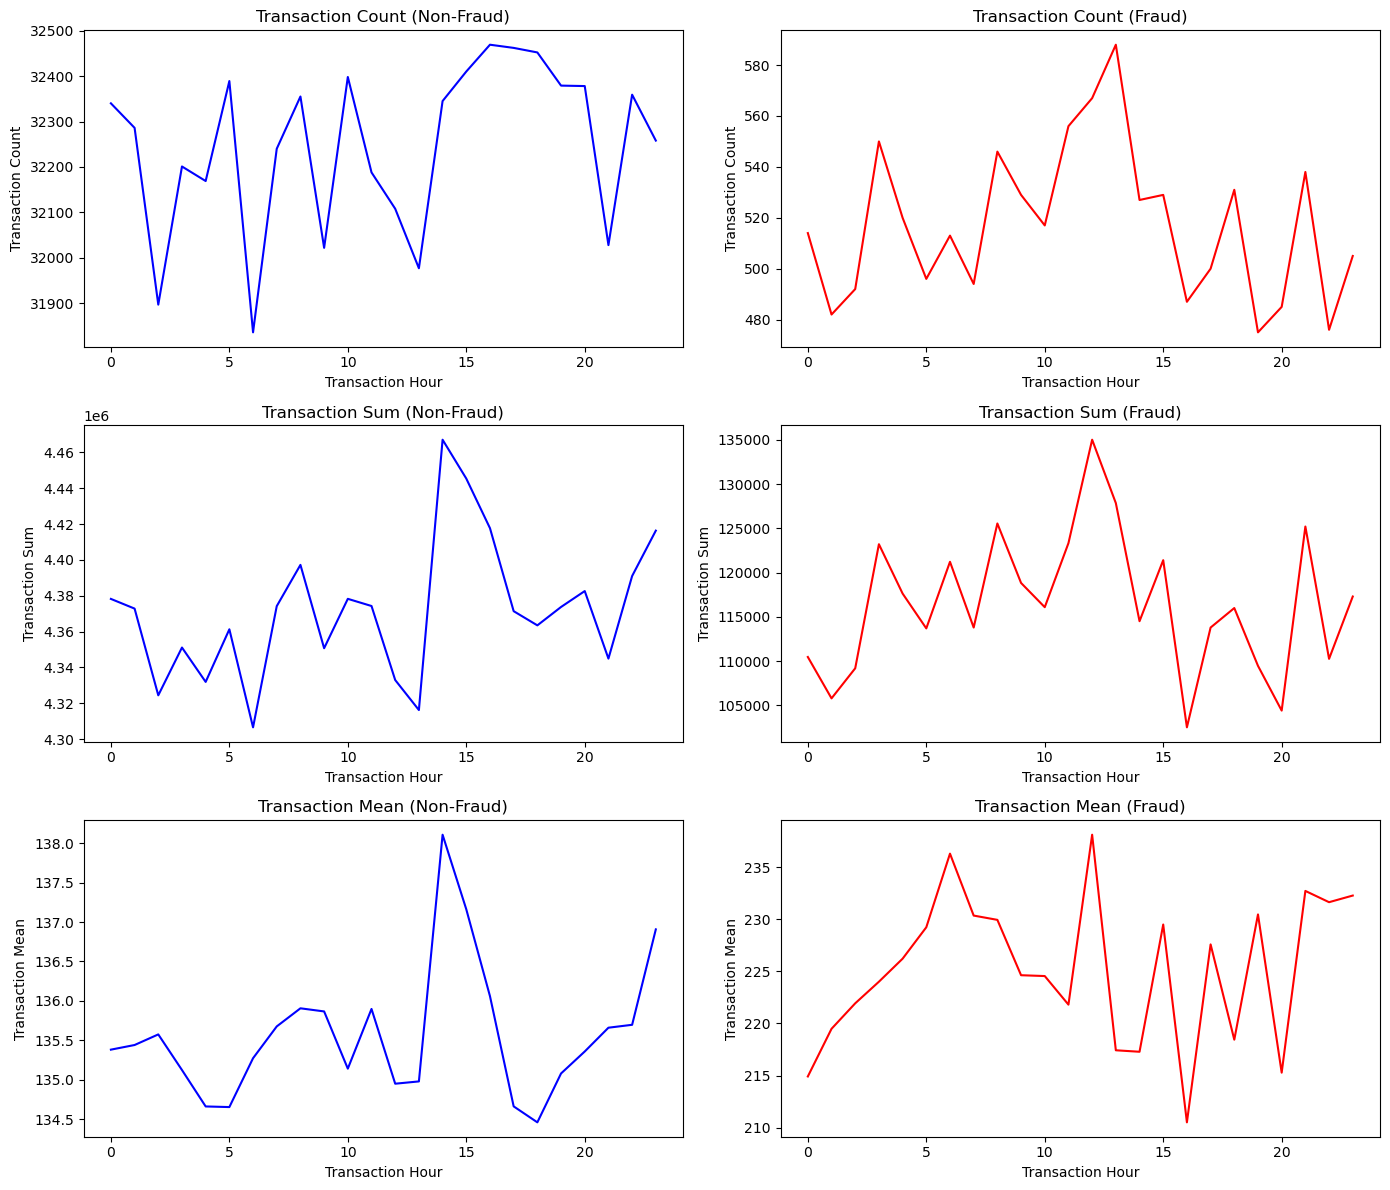

In [10]:
# transaction date time column
data['trans_month'] = (data['transactionDateTime'].dt.month).astype('int64') # extract month
data['trans_day'] = (data['transactionDateTime'].dt.day).astype('int64') # extract day
data['trans_hour'] = (data['transactionDateTime'].dt.hour).astype('int64') # extract hour
data['trans_isNight'] = (data['trans_hour'] <= 6).astype('int64') # 1 for night, 0 for day
data['trans_isWeekend'] = (data['transactionDateTime'].dt.dayofweek >= 5).astype('int64')  # 1 for Saturday and Sunday, 0 for weekdays


hour_trans = data.groupby(['trans_hour', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
hour_trans_df = pd.DataFrame(hour_trans, columns = ['trans_hour', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Hour")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_hour', y=metric, data=hour_trans_df.loc[hour_trans_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Hour")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

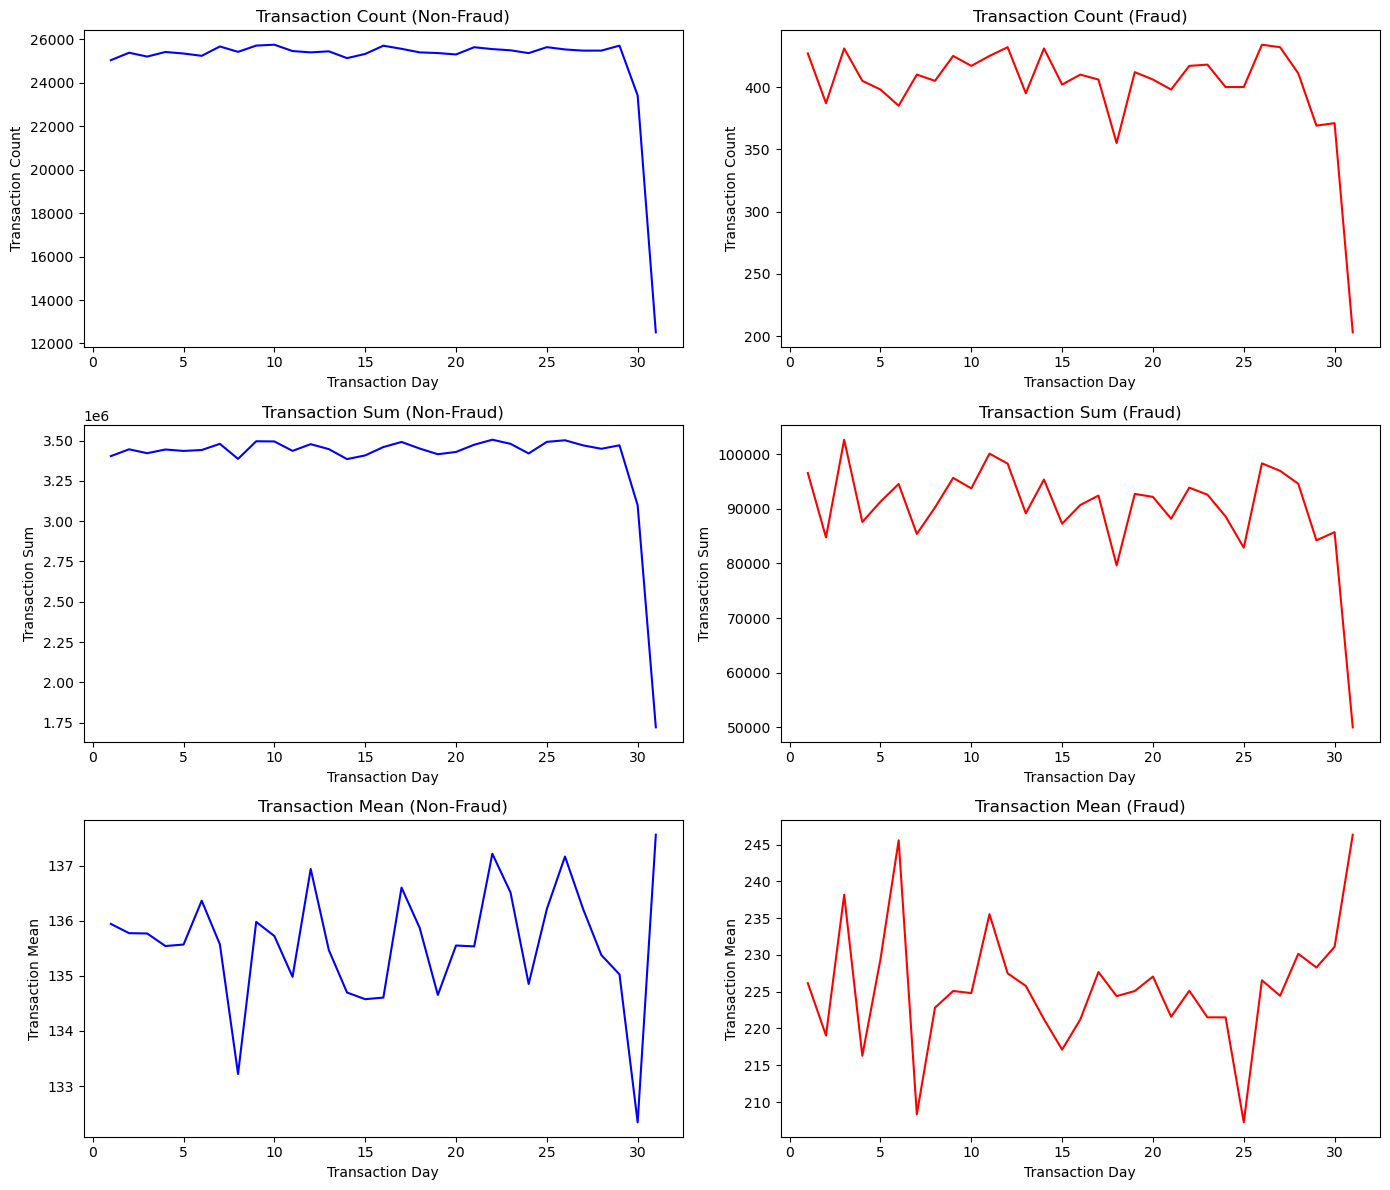

In [11]:
trans_day = data.groupby(['trans_day', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_day_df = pd.DataFrame(trans_day, columns = ['trans_day', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Day")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_day', y=metric, data=trans_day_df.loc[trans_day_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Day")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

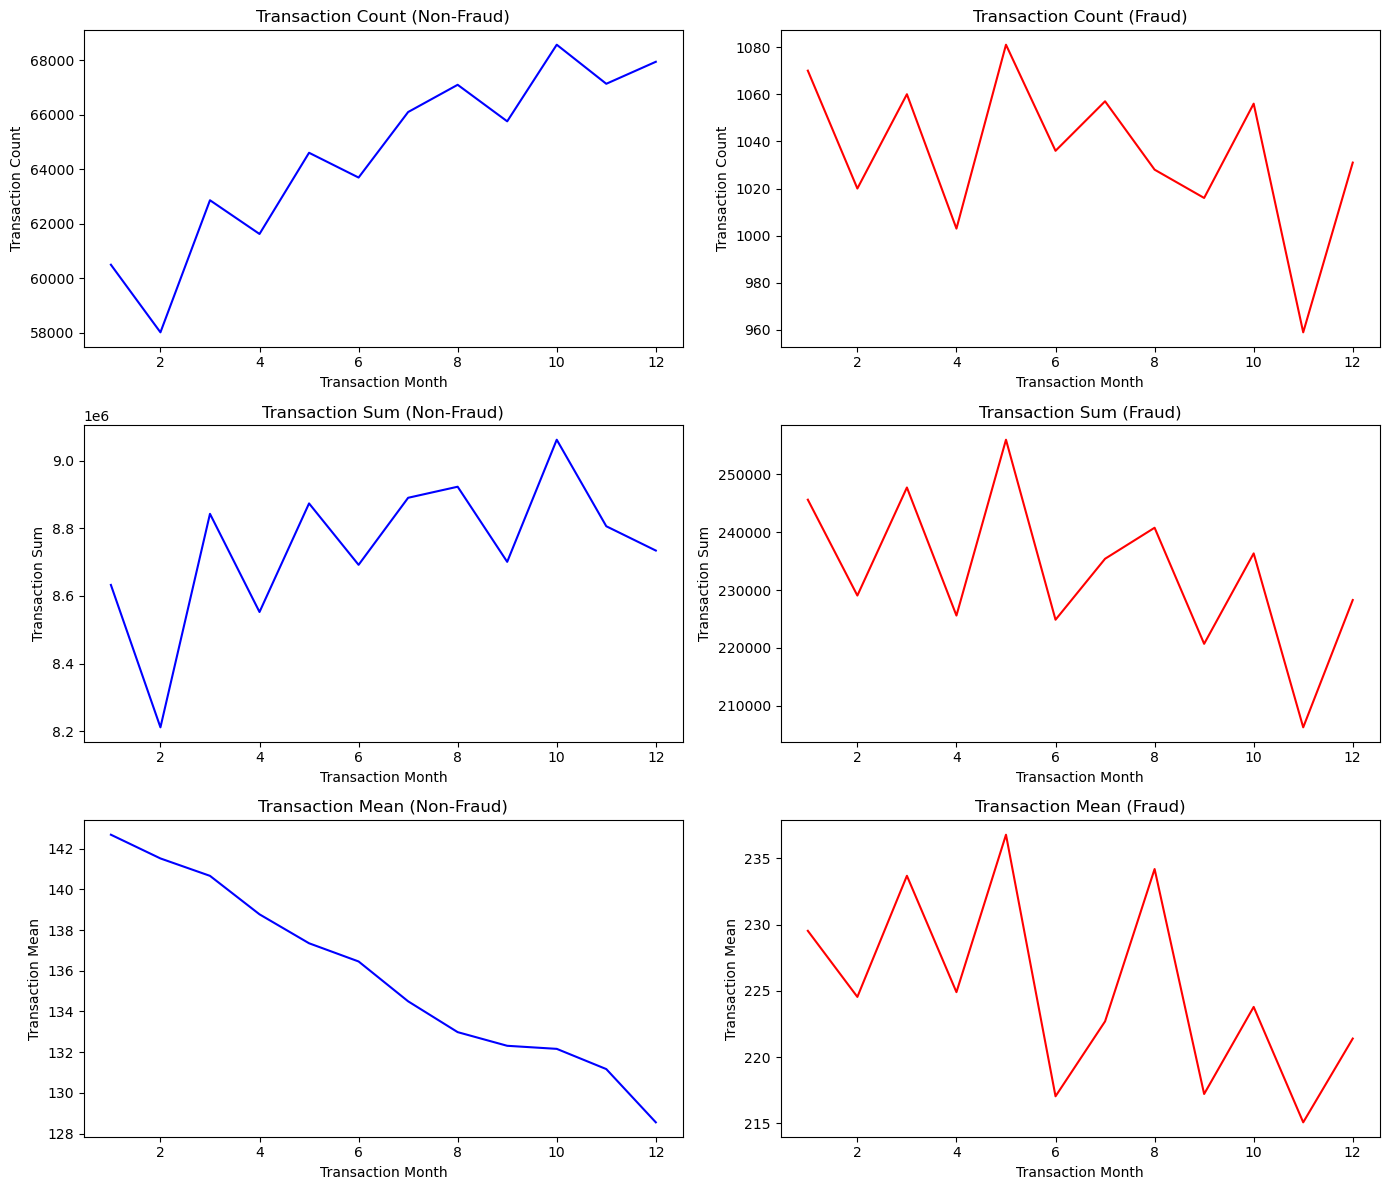

In [12]:
trans_month = data.groupby(['trans_month', 'isFraud'])['transactionAmount'].aggregate(['count', 'sum','mean']).reset_index()
trans_month_df = pd.DataFrame(trans_month, columns = ['trans_month', 'isFraud','count',  'sum','mean'])

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
metrics = ['count', 'sum', 'mean']
titles = ['Transaction Count', 'Transaction Sum', 'Transaction Mean']

# Plot for non-fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 0], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 0], color='blue')
    axes[i, 0].set_title(f"{titles[i]} (Non-Fraud)")
    axes[i, 0].set_xlabel("Transaction Month")
    axes[i, 0].set_ylabel(titles[i])

# Plot for fraudulent transactions
for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i, 1], x='trans_month', y=metric, data=trans_month_df.loc[trans_month_df.isFraud == 1], color='red')
    axes[i, 1].set_title(f"{titles[i]} (Fraud)")
    axes[i, 1].set_xlabel("Transaction Month")
    axes[i, 1].set_ylabel(titles[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [13]:
def customerId_behaviour(df , windows = [1, 7]):
    df = df.sort_values('transactionDateTime')
    df.index = df.transactionDateTime
    
    for k in windows:
        sum_trans = df.transactionAmount.rolling(str(k) +'d').sum()
        count_trans = df.transactionAmount.rolling(str(k) +'d').count()
        avg_trans = sum_trans / count_trans
        df['trans_avg'+ str(k) + 'days'] = list(avg_trans)
        df['trans_count' + str(k) + 'days'] = list(count_trans)
    return df

data = data.groupby('customerId').apply(lambda x : customerId_behaviour(x , windows = [1, 7]))
data = data.reset_index(drop=True)
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,cvvMatch,trans_month,trans_day,trans_hour,trans_isNight,trans_isWeekend,trans_avg1days,trans_count1days,trans_avg7days,trans_count7days
0,100088067,50000.0,50000.00,2016-01-12 00:59:52,205.13,ez putt putt,US,US,02,01,...,1,1,12,0,1,0,205.130,1.0,205.130000,1.0
1,100088067,50000.0,49794.87,2016-01-12 19:49:41,46.43,dinosaur sandwitch bar,US,US,05,01,...,1,1,12,19,0,0,125.780,2.0,125.780000,2.0
2,100088067,50000.0,49748.44,2016-01-17 15:41:46,378.67,mobile ecards,US,US,05,01,...,1,1,17,15,0,1,378.670,1.0,210.076667,3.0
3,100088067,50000.0,50000.00,2016-02-02 19:57:18,66.07,ez putt putt,US,US,02,01,...,1,2,2,19,0,0,66.070,1.0,66.070000,1.0
4,100088067,50000.0,49933.93,2016-02-03 04:48:54,141.60,34th bbq,US,US,09,08,...,1,2,3,4,1,0,103.835,2.0,103.835000,2.0


In [14]:
# for each customer calculate the time difference between transactions
data = data.sort_values(by=['customerId', 'transactionDateTime'])
data['time_diff_transaction'] = data.groupby('customerId')['transactionDateTime'].diff().dt.days
data['time_diff_transaction'] = data['time_diff_transaction'].fillna(0)

In [15]:
data = data.sort_values(by = 'transactionDateTime')

data = data.drop(['currentExpDate','accountOpenDate', 'dateOfLastAddressChange'], axis = 1)

In [16]:
pd.set_option('display.max_columns', None)
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvvMatch,trans_month,trans_day,trans_hour,trans_isNight,trans_isWeekend,trans_avg1days,trans_count1days,trans_avg7days,trans_count7days,time_diff_transaction
317331,419104777,50000.0,50000.0,2016-01-01 00:01:02,44.09,washington post,US,US,09,01,subscriptions,5010,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,44.09,1.0,44.09,1.0,0.0
507244,674577133,5000.0,5000.0,2016-01-01 00:01:44,329.57,staples.com,US,US,09,08,online_retail,1693,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,329.57,1.0,329.57,1.0,0.0
758422,958438658,20000.0,20000.0,2016-01-01 00:01:47,164.57,cheapfast.com,US,US,05,01,online_retail,2062,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,164.57,1.0,164.57,1.0,0.0
665350,851126461,10000.0,10000.0,2016-01-01 00:02:04,122.83,discount.com,US,US,02,08,online_retail,7359,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,122.83,1.0,122.83,1.0,0.0
37336,148963316,2500.0,2500.0,2016-01-01 00:02:19,0.00,fast repair,US,US,05,01,auto,1785,ADDRESS_VERIFICATION,0.0,0,0,0,1,1,1,0,1,0,0.00,1.0,0.00,1.0,0.0


### **EXPLORATORY DATA ANALYSIS**

In [18]:
def hist_plt(col):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    # Non-fraud (isFraud == 0)
    sns.histplot(data=data[data['isFraud'] == 0], x=col, color='orange', ax=axes[0])
    axes[0].set_title(f'{col} - Non-Fraud')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)

    # Fraud (isFraud == 1)
    sns.histplot(data=data[data['isFraud'] == 1], x=col, color='blue', ax=axes[1])
    axes[1].set_title(f'{col} - Fraud')
    axes[1].set_xlabel('Value')
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def correlation_table(df, col):
    numerical_feat = df.select_dtypes(['int64', 'float']).columns
    correlation = []
    for i in numerical_feat:
        correlation.append(round(df[i].corr(df[col], method='spearman'),3))
    data_cor = pd.DataFrame({'col': numerical_feat, 'cor': correlation})
    return data_cor


#### **TARGET**
**Is data balanced?**

isFraud
0    98.420958
1     1.579042
Name: proportion, dtype: float64


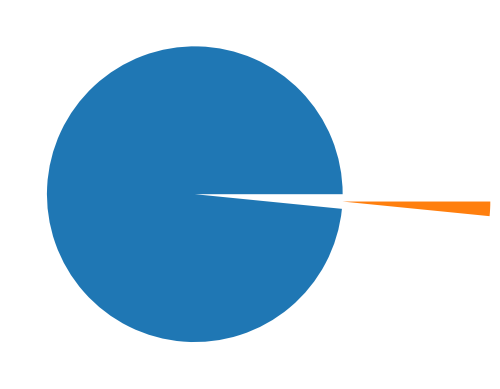

In [20]:
print(data["isFraud"].value_counts(normalize = True) * 100 )
# plot the classes of the target 
target  = data["isFraud"].value_counts(normalize = True) * 100
plt.pie(target.values, target.index);

The dataset is highly unbalanced with 98.42% nonfraud and 1.58% fraud. 

In [22]:
non_fraud = data["isFraud"].value_counts(normalize = True)[0]
fraud = data["isFraud"].value_counts(normalize = True)[1]
print(f'The imbalance ration is almost 1: {int(non_fraud/fraud)} which shows a severe imbalance in our data')

The imbalance ration is almost 1: 62 which shows a severe imbalance in our data


In [23]:
cor_df = correlation_table(data, 'isFraud')
cor_df.sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
6,isFraud,1.000
2,transactionAmount,0.074
13,trans_avg1days,0.053
15,trans_avg7days,0.035
16,trans_count7days,0.018


<Axes: xlabel='availableMoney', ylabel='transactionAmount'>

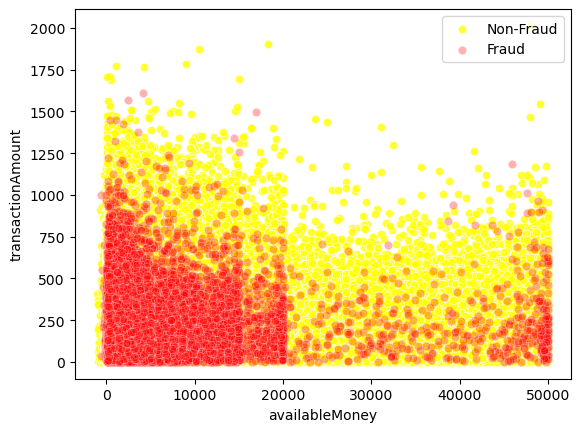

In [24]:
# Filter data by fraud status
fraud = data[data['isFraud'] == 1]
non_fraud = data[data['isFraud'] == 0]

# Plot non-fraud transactions (less transparent)
sns.scatterplot(data=non_fraud, x='availableMoney', y='transactionAmount', 
                color='yellow', alpha=0.8, label='Non-Fraud')

# Plot fraud transactions (more transparent)
sns.scatterplot(data=fraud, x='availableMoney', y='transactionAmount', 
                color='red', alpha=0.3, label='Fraud')

#### **Cusromer Id Column Analysis**

**Question 2: Does fraud occur only among customers with a high number of transactions?**

In [26]:
# customers with the highest number of transaction
data.customerId.value_counts().head(10)

customerId
380680241    32850
882815134    13189
570884863    10867
246251253    10172
369308035     7229
724518977     6283
894938833     6101
419709514     5930
832842201     5850
208319653     5235
Name: count, dtype: int64

In [27]:
pd.crosstab(data.customerId, data.isFraud,  normalize='index').sort_values(by = 1, ascending = False).head(10)

isFraud,0,1
customerId,,
749645399,0.000000,1.000000
356886744,0.000000,1.000000
494400203,0.500000,0.500000
666461201,0.500000,0.500000
275266909,0.666667,0.333333
938195288,0.692982,0.307018
319012201,0.714286,0.285714
336236533,0.722222,0.277778
838703913,0.726415,0.273585


In [28]:
data_id = data.copy()
customer_transaction_count = data_id.groupby('customerId').size()
data_id['total_trans_perCost'] = data_id['customerId'].map(customer_transaction_count)
data_id[['total_trans_perCost', 'isFraud']].corr(method='spearman')

,total_trans_perCost,isFraud
total_trans_perCost,1.0000,0.0183
isFraud,0.0183,1.0000


#### **Metchant Related Columns**

In [30]:
merchant_data = data[['merchantName', 'merchantCountryCode', 'merchantCategoryCode','transactionAmount', 'isFraud']]
merchant_data.groupby('isFraud').agg(merchantName = ('merchantName', 'nunique'),
                                   merchantCountryCode = ('merchantCountryCode', 'nunique'),
                                   merchantCategoryCode = ('merchantCategoryCode', 'nunique'))

,merchantName,merchantCountryCode,merchantCategoryCode
isFraud,,,
0,205,5,19
1,173,5,13


in 13 out of 19 merchantCategoryCode fraud happen and in 173 out of 205 merchantName

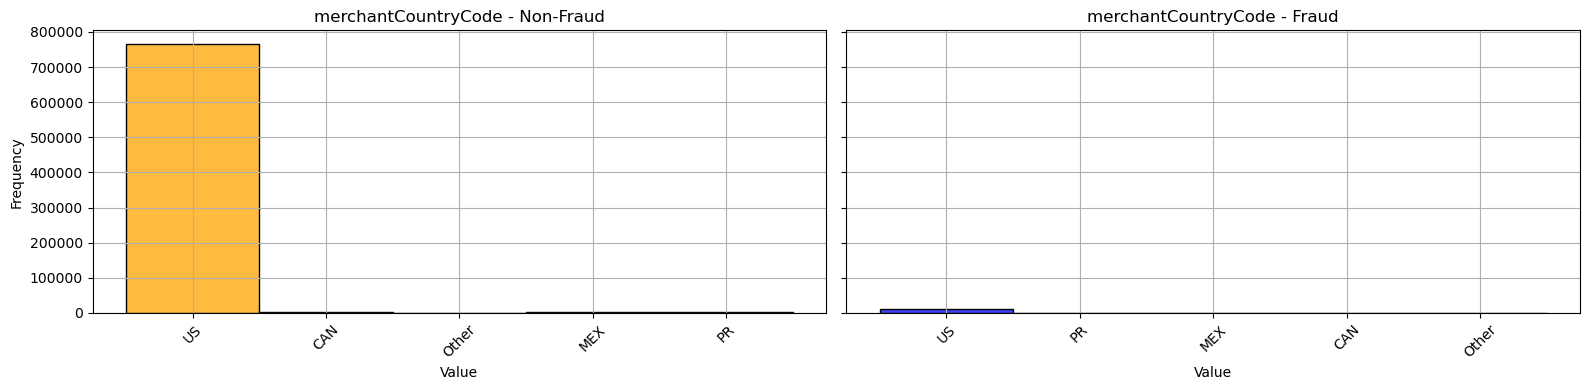

In [32]:
hist_plt('merchantCountryCode')

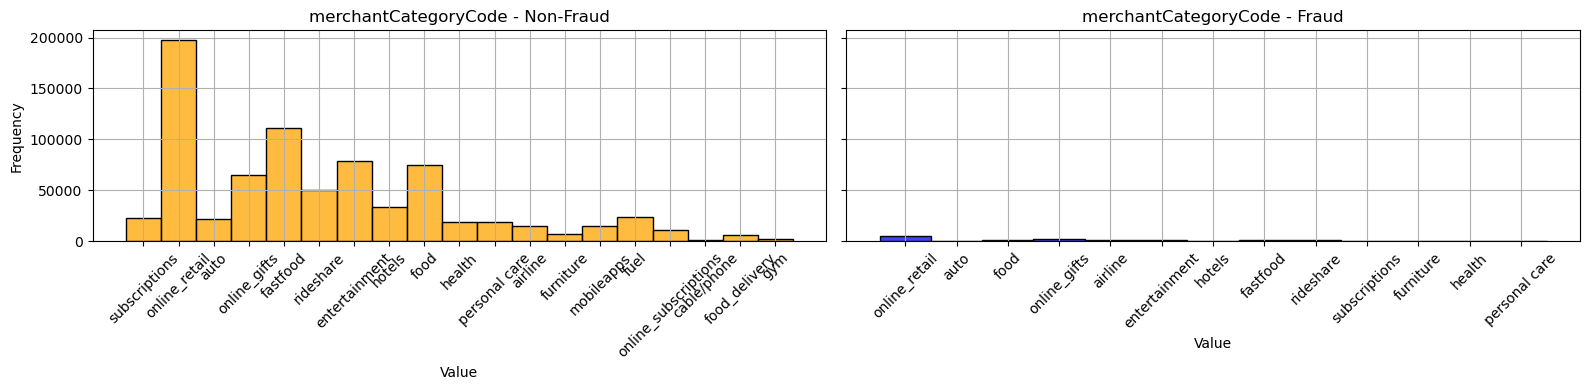

In [33]:
hist_plt('merchantCategoryCode')

**Question 3: country with the highest rate of fraud**

In [35]:
# Create a pivot table that aggregates by count and sum
country = merchant_data.pivot_table(
    index='merchantCountryCode', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
country['rate of fraud'] = round((country['count'][1]/country['count'][0])*100, 2)
country['% Fraud Amount'] = round((country['sum'][1]/country['sum'][0]) * 100, 2)
country[['rate of fraud', '% Fraud Amount']]

,rate of fraud,% Fraud Amount
isFraud,,
merchantCountryCode,,
CAN,2.36,4.26
MEX,2.08,3.17
Other,12.77,25.78
PR,1.76,3.17
US,1.59,2.64


#### **Merhcant Category Code**

**Question 4 : Safest and riskier merchant category**

In [38]:
category = merchant_data.pivot_table(
    index='merchantCategoryCode', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
category['rate of fraud'] = round((category['count'][1]/category['count'][0])*100, 2)
category['% Fraud Amount'] = round((category['sum'][1]/category['sum'][0]) * 100, 2)
category[['rate of fraud', '% Fraud Amount']].sort_values(by = 'rate of fraud',ascending = False)


,rate of fraud,% Fraud Amount
isFraud,,
merchantCategoryCode,,
airline,3.59,5.25
rideshare,2.55,4.19
online_retail,2.50,4.22
online_gifts,2.48,4.25
furniture,1.41,1.79
food,1.36,1.98
auto,1.28,1.93
entertainment,1.21,1.52


In [39]:
for i in ['mobileapps','fuel','food_delivery', 'online_subscriptions','cable/phone','gym']:
    data["merchantCategoryCode"] = data["merchantCategoryCode"].replace(i, "Other")

#### **Merchant Name**

In [41]:
name = merchant_data.pivot_table(
    index='merchantName', 
    columns='isFraud', 
    values='transactionAmount', 
    aggfunc={'transactionAmount': ['count', 'sum']}, 
    fill_value=0
)
name['rate of fraud'] = round((name['count'][1]/name['count'][0])*100, 2)
name['% Fraud Amount'] = round((name['sum'][1]/name['sum'][0]) * 100, 2)
nameData = name[['rate of fraud', '% Fraud Amount']].sort_values(by = 'rate of fraud',ascending = False)
nameData

,rate of fraud,% Fraud Amount
isFraud,,
merchantName,,
american airlines,10.37,11.99
fresh flowers,7.11,12.81
ethanallen.com,5.15,5.78
convenient auto services,4.44,4.11
rove concepts,4.42,5.77
...,...,...
sunoco gas,0.00,0.00
dailyomnivore,0.00,0.00


In [42]:
nameData_nonzero = nameData.head(173)

In [43]:
data['merchantName'] = data['merchantName'].apply(lambda x: x if x in nameData_nonzero.index else 'Other')
data['merchantName'].value_counts()

merchantName
Other               60911
amc                 37942
ez putt putt        30712
uber                25613
lyft                25523
                    ...  
86th massage          276
west end massage      239
aloft                 173
marriott hotels       167
holiday inn           166
Name: count, Length: 174, dtype: int64

In [44]:
pd.set_option('display.max_columns', None)
data.head(5)

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvvMatch,trans_month,trans_day,trans_hour,trans_isNight,trans_isWeekend,trans_avg1days,trans_count1days,trans_avg7days,trans_count7days,time_diff_transaction
317331,419104777,50000.0,50000.0,2016-01-01 00:01:02,44.09,washington post,US,US,09,01,subscriptions,5010,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,44.09,1.0,44.09,1.0,0.0
507244,674577133,5000.0,5000.0,2016-01-01 00:01:44,329.57,staples.com,US,US,09,08,online_retail,1693,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,329.57,1.0,329.57,1.0,0.0
758422,958438658,20000.0,20000.0,2016-01-01 00:01:47,164.57,cheapfast.com,US,US,05,01,online_retail,2062,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,164.57,1.0,164.57,1.0,0.0
665350,851126461,10000.0,10000.0,2016-01-01 00:02:04,122.83,discount.com,US,US,02,08,online_retail,7359,PURCHASE,0.0,0,0,0,1,1,1,0,1,0,122.83,1.0,122.83,1.0,0.0
37336,148963316,2500.0,2500.0,2016-01-01 00:02:19,0.00,fast repair,US,US,05,01,auto,1785,ADDRESS_VERIFICATION,0.0,0,0,0,1,1,1,0,1,0,0.00,1.0,0.00,1.0,0.0


#### **Transaction Amount**

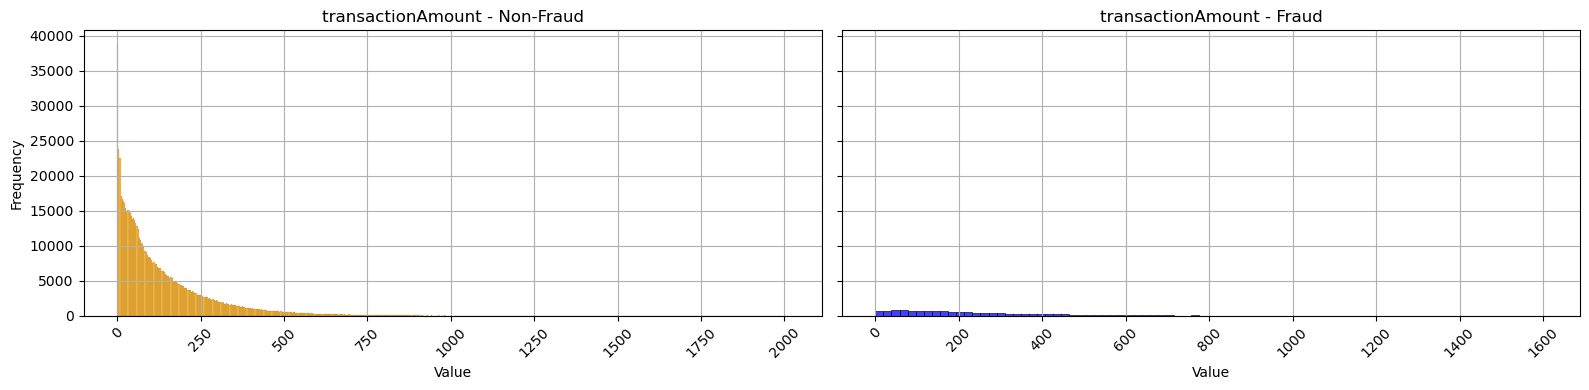

In [46]:
hist_plt('transactionAmount')

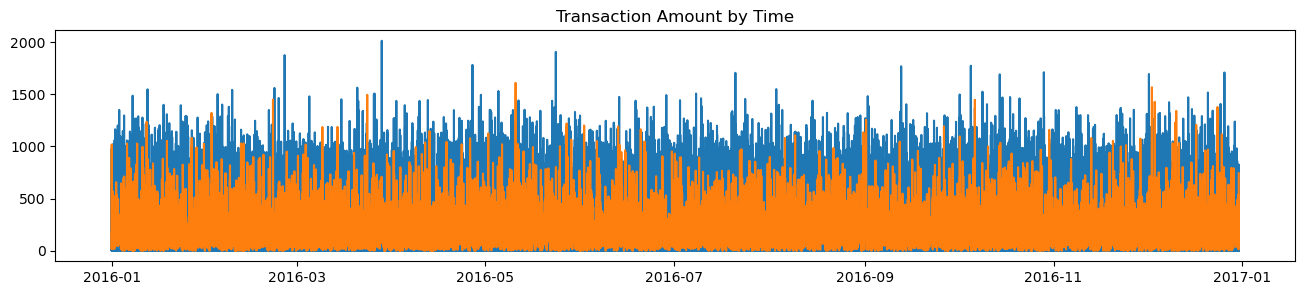

In [47]:
fraud = data[data['isFraud'] == 1 ] 
No_fraud = data[data['isFraud'] == 0]
fig = plt.figure(figsize=(16, 3))
plt.plot(No_fraud.transactionDateTime,No_fraud.transactionAmount)
plt.plot(fraud.transactionDateTime,fraud.transactionAmount)
plt.title('Transaction Amount by Time')
plt.show()

In [48]:
fraud.transactionAmount.value_counts().head(10)

transactionAmount
0.00      122
34.63       6
156.01      6
210.11      5
46.37       5
143.89      4
144.58      4
312.77      4
148.98      4
92.53       4
Name: count, dtype: int64

In [49]:
No_fraud.transactionAmount.value_counts().head(10)

transactionAmount
0.00     22103
8.21       132
49.30      125
8.81       124
7.53       119
4.39       119
8.22       117
4.69       114
8.04       112
36.01      111
Name: count, dtype: int64

In [50]:
correlation_table(data, 'transactionAmount').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
2,transactionAmount,1.000
13,trans_avg1days,0.660
15,trans_avg7days,0.383
16,trans_count7days,0.084
6,isFraud,0.074


#### **Credit Limit**

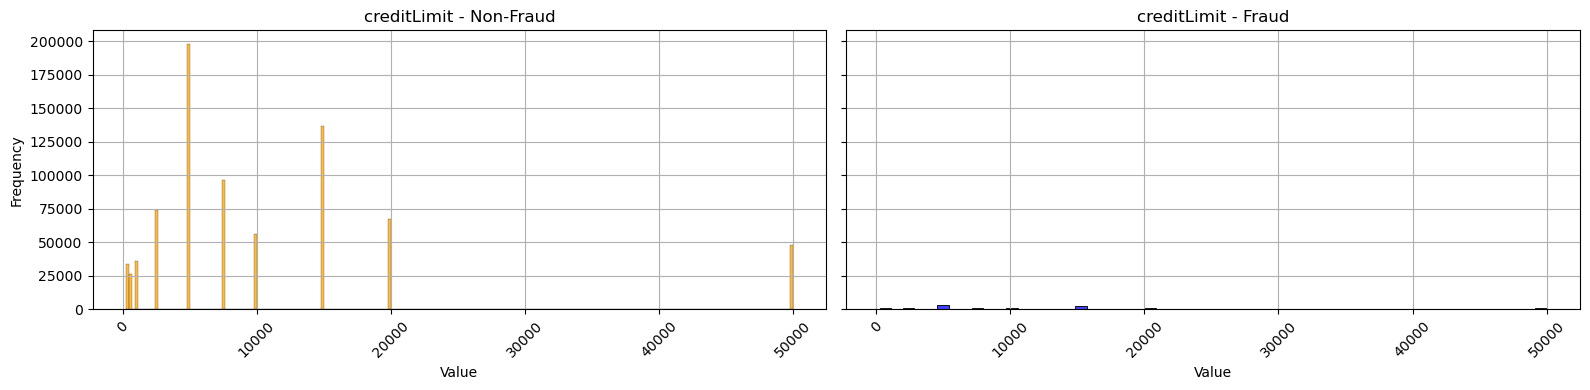

In [52]:
hist_plt('creditLimit')

In [53]:
correlation_table(data, 'creditLimit').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
0,creditLimit,1.000
1,availableMoney,0.830
3,currentBalance,0.576
16,trans_count7days,0.035
14,trans_count1days,0.035


#### **availableMoney**

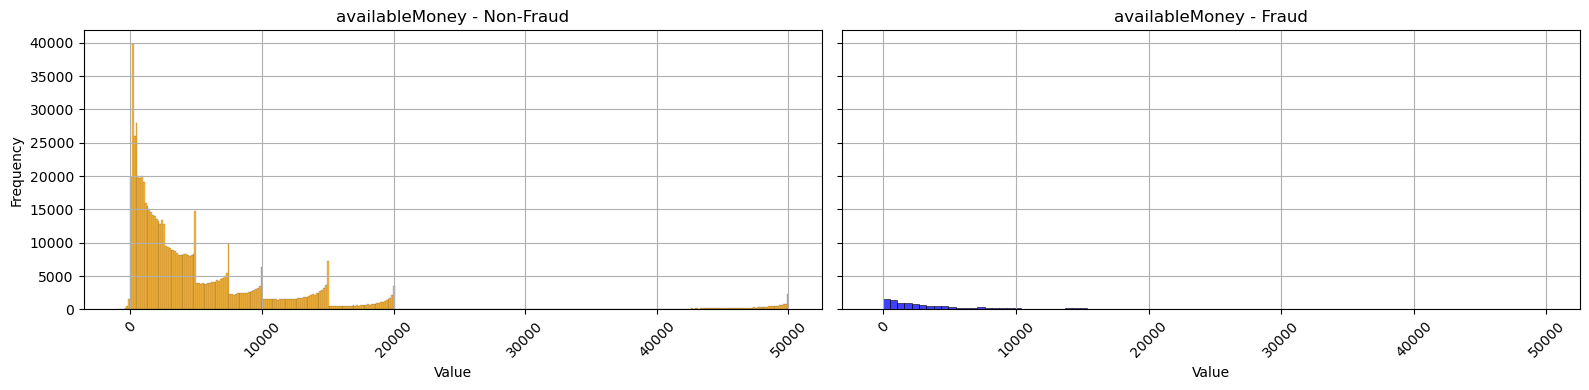

In [55]:
hist_plt('availableMoney')

In [56]:
correlation_table(data, 'availableMoney').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
1,availableMoney,1.000
0,creditLimit,0.830
3,currentBalance,0.145
17,time_diff_transaction,0.132
11,trans_isNight,0.004


#### **acqCountry**

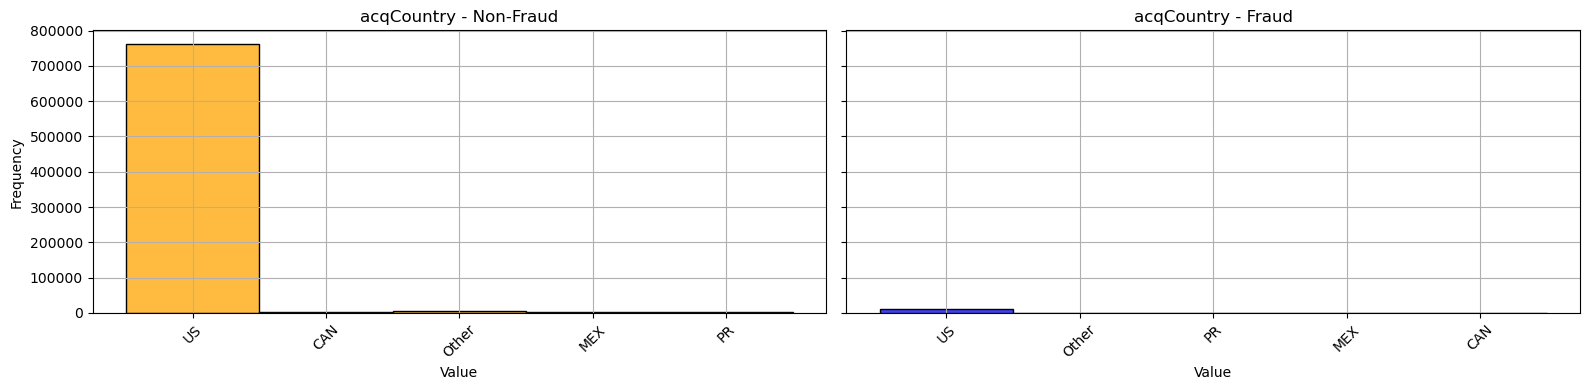

In [58]:
hist_plt('acqCountry')

#### **posEntryMode**

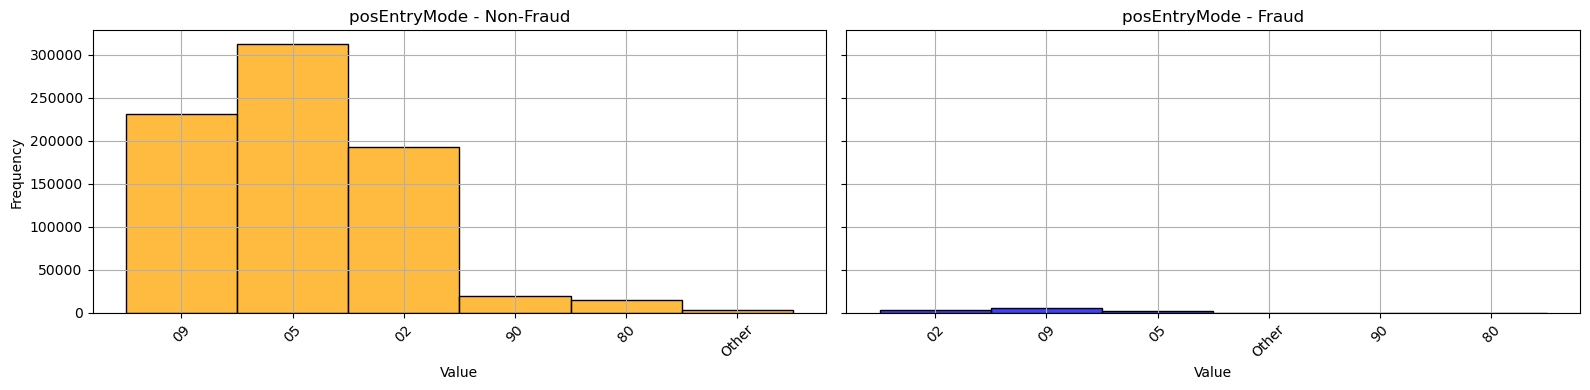

In [60]:
hist_plt('posEntryMode')

#### **posConditionCode**

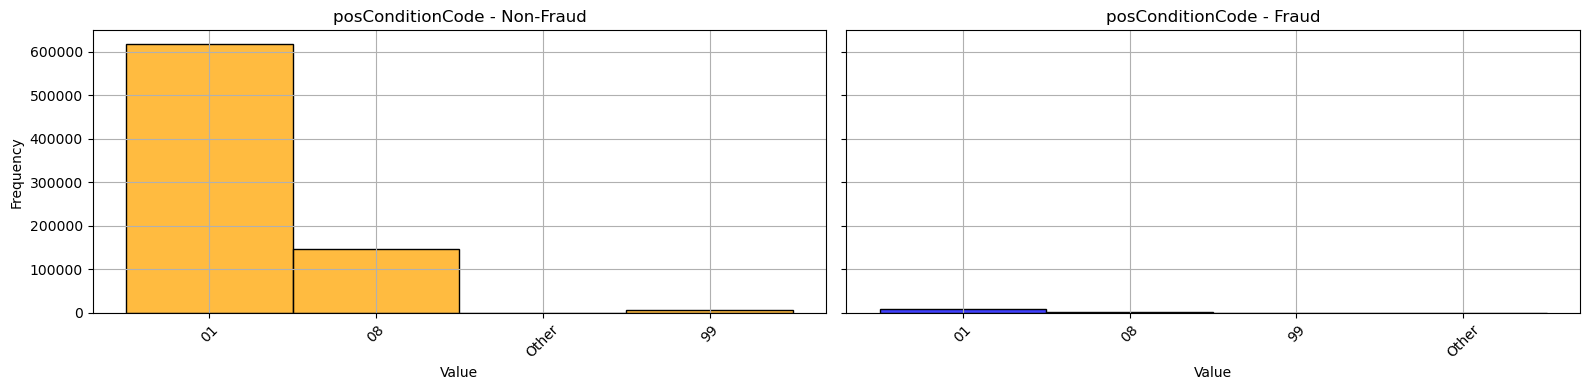

In [62]:
hist_plt('posConditionCode')

#### **cardLast4Digits**

In [64]:
fraud.cardLast4Digits.value_counts().head(10)

cardLast4Digits
593     783
6002    278
9522    272
7629    211
2178    207
7654    155
7256    153
8971    139
1142    127
8208    116
Name: count, dtype: int64

In [65]:
No_fraud.cardLast4Digits.value_counts().head(10)

cardLast4Digits
593     32163
2194    10808
6002     9894
6580     6703
8502     6500
2178     5723
0000     5437
7629     5024
2701     4772
619      4507
Name: count, dtype: int64

#### **transactionType**

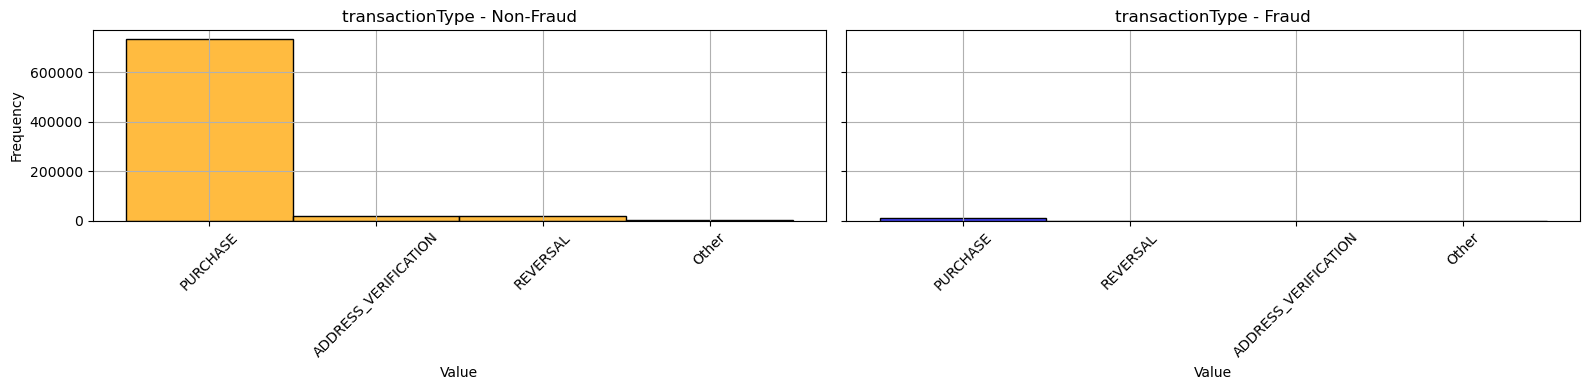

In [67]:
hist_plt('transactionType')

#### **currentBalance**

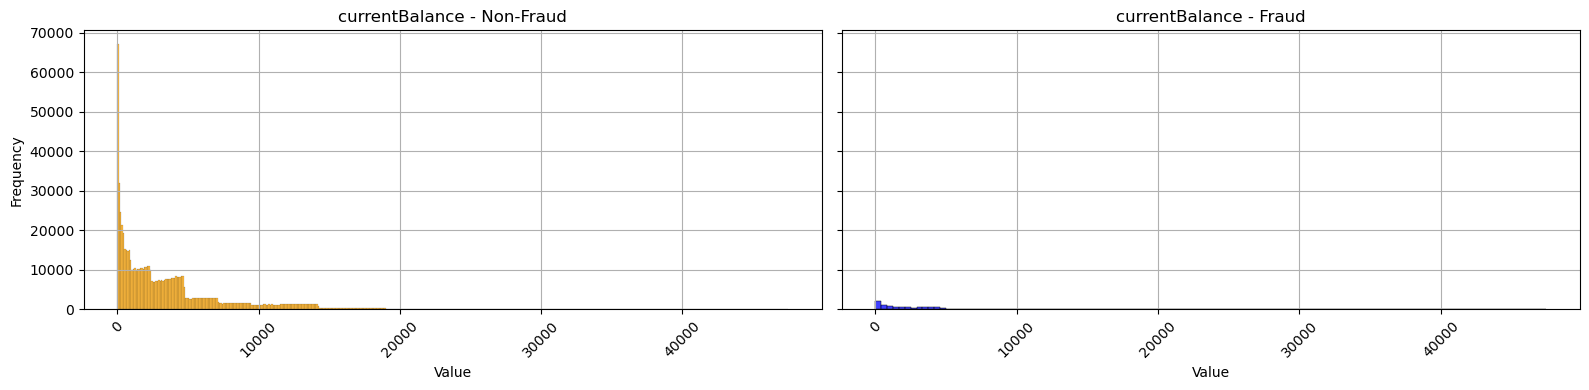

In [69]:
hist_plt('currentBalance')

In [70]:
correlation_table(data, 'currentBalance').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
3,currentBalance,1.000
0,creditLimit,0.576
16,trans_count7days,0.431
14,trans_count1days,0.368
15,trans_avg7days,0.164


#### **cardPresent**

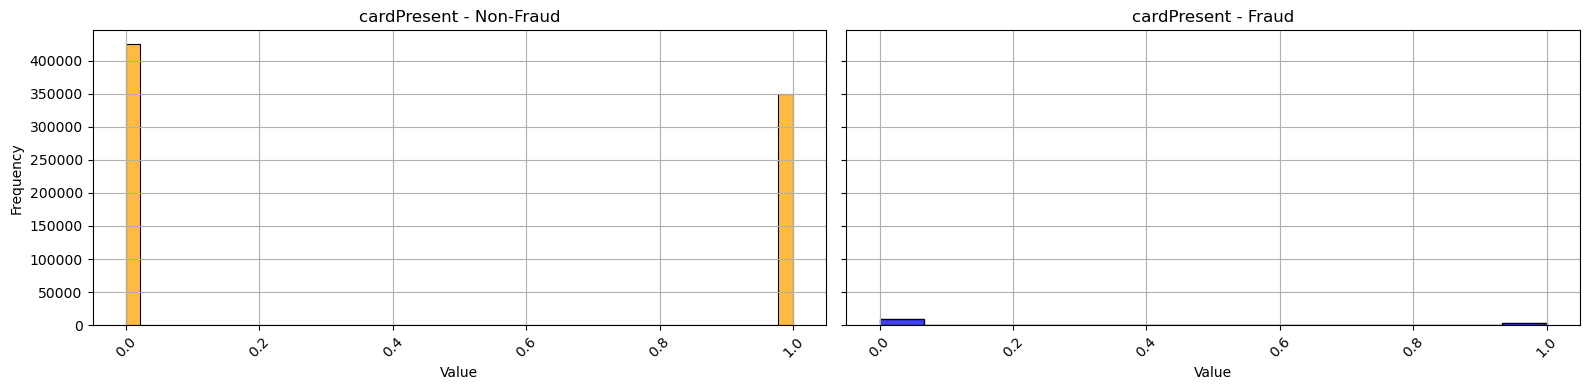

In [72]:
hist_plt('cardPresent')

In [73]:
correlation_table(data, 'cardPresent').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
4,cardPresent,1.000
2,transactionAmount,0.072
5,expirationDateKeyInMatch,0.040
13,trans_avg1days,0.032
15,trans_avg7days,0.017


#### **expirationDateKeyInMatch**

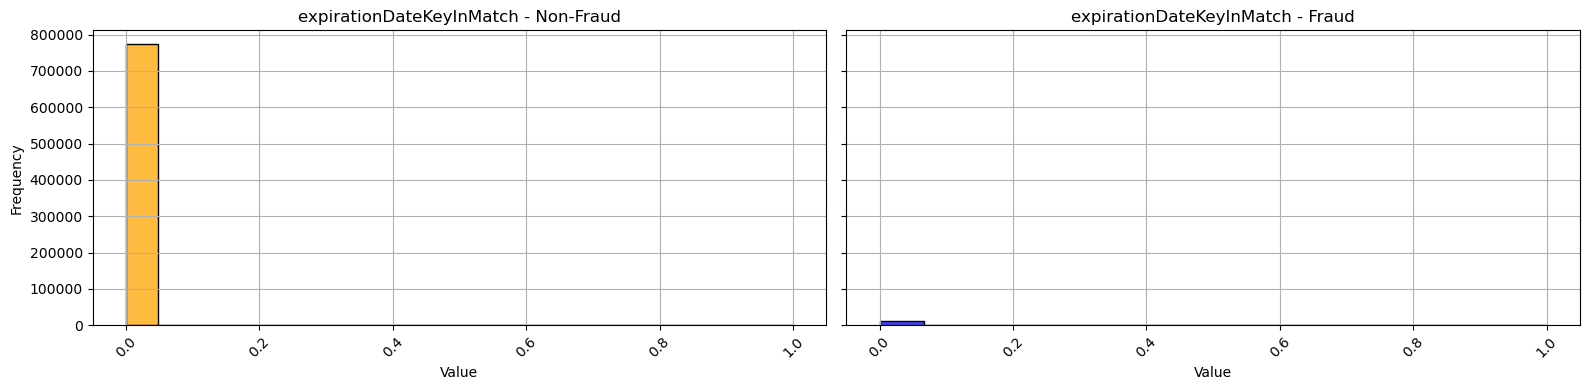

In [75]:
hist_plt('expirationDateKeyInMatch')

In [76]:
correlation_table(data, 'expirationDateKeyInMatch').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
5,expirationDateKeyInMatch,1.000
4,cardPresent,0.040
2,transactionAmount,0.002
15,trans_avg7days,0.001
13,trans_avg1days,0.001


#### **cvvMatch**

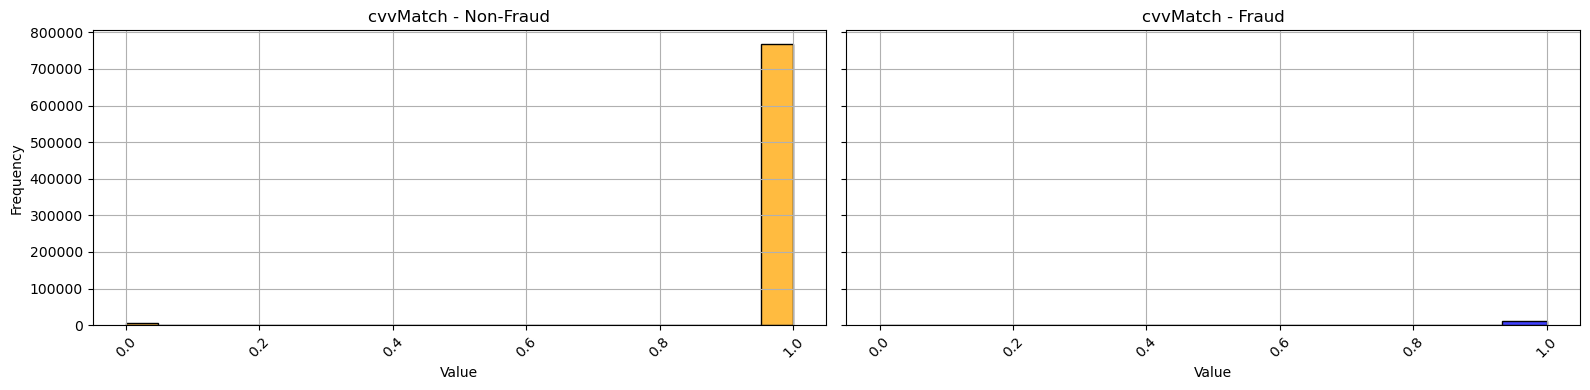

In [78]:
hist_plt('cvvMatch')

In [79]:
correlation_table(data, 'cvvMatch').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
7,cvvMatch,1.000
4,cardPresent,0.003
3,currentBalance,0.002
15,trans_avg7days,0.002
0,creditLimit,0.001


#### **trans_month**

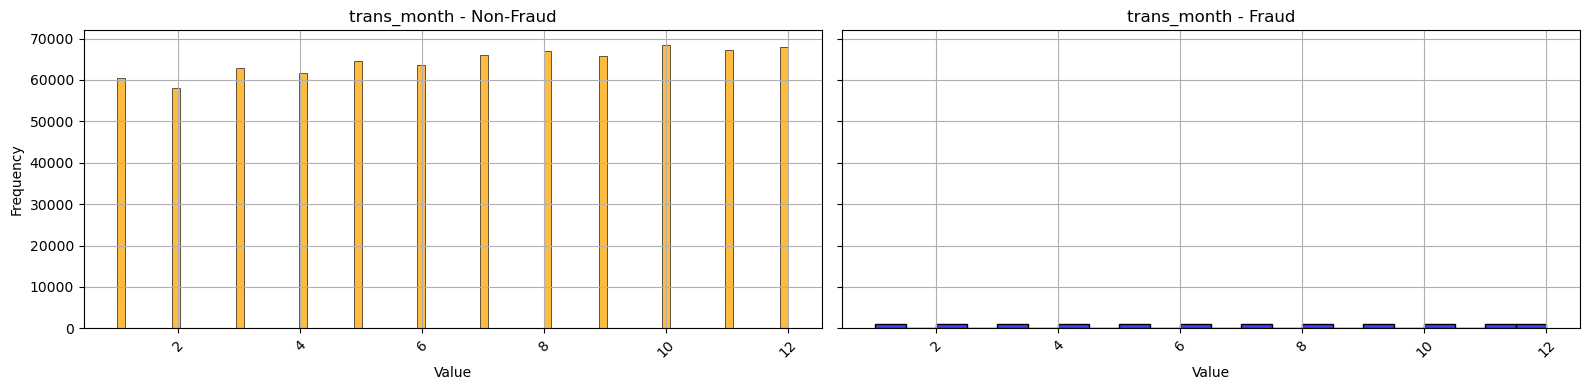

In [81]:
hist_plt('trans_month')

In [82]:
correlation_table(data, 'trans_month').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
8,trans_month,1.000
3,currentBalance,0.057
17,time_diff_transaction,0.046
11,trans_isNight,0.000
0,creditLimit,0.000


#### **trans_day**

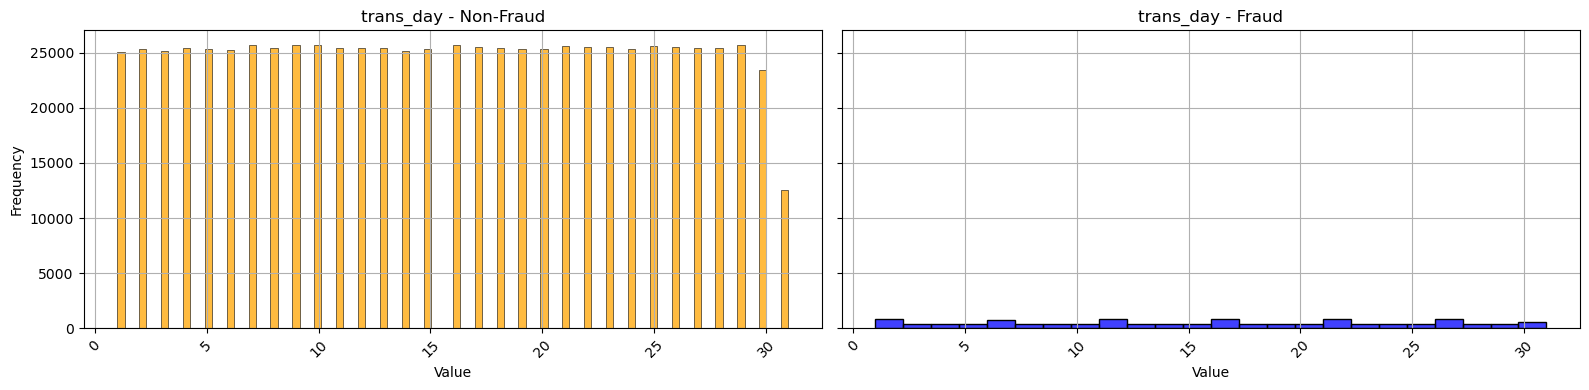

,col,cor
9,trans_day,1.000
3,currentBalance,0.124
17,time_diff_transaction,0.012
16,trans_count7days,0.011
4,cardPresent,0.003


In [84]:
hist_plt('trans_day')
correlation_table(data, 'trans_day').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_hour**

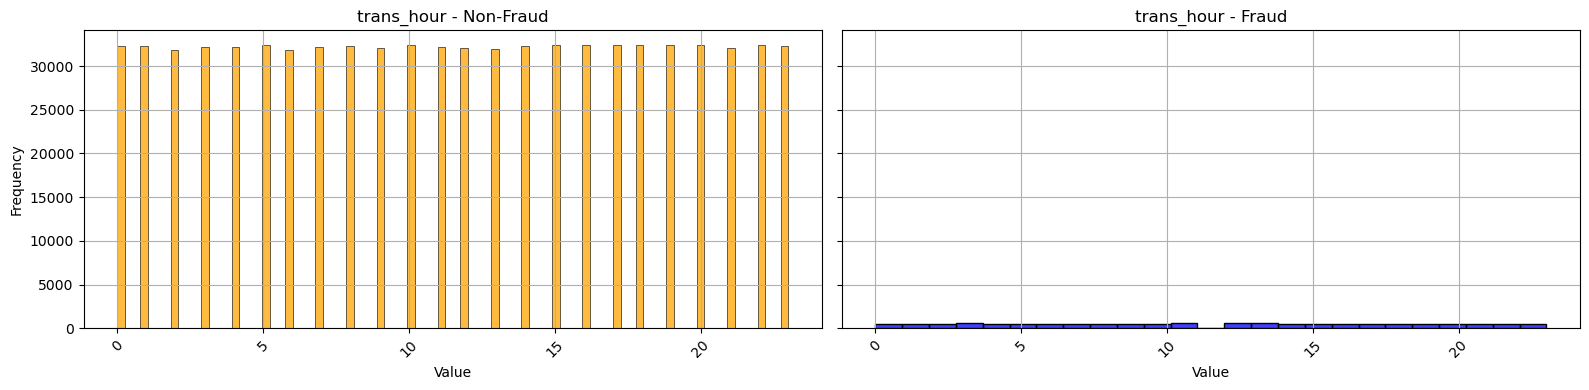

,col,cor
10,trans_hour,1.000
3,currentBalance,0.006
12,trans_isWeekend,0.002
2,transactionAmount,0.002
4,cardPresent,0.002


In [86]:
hist_plt('trans_hour')
correlation_table(data, 'trans_hour').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_isNight**

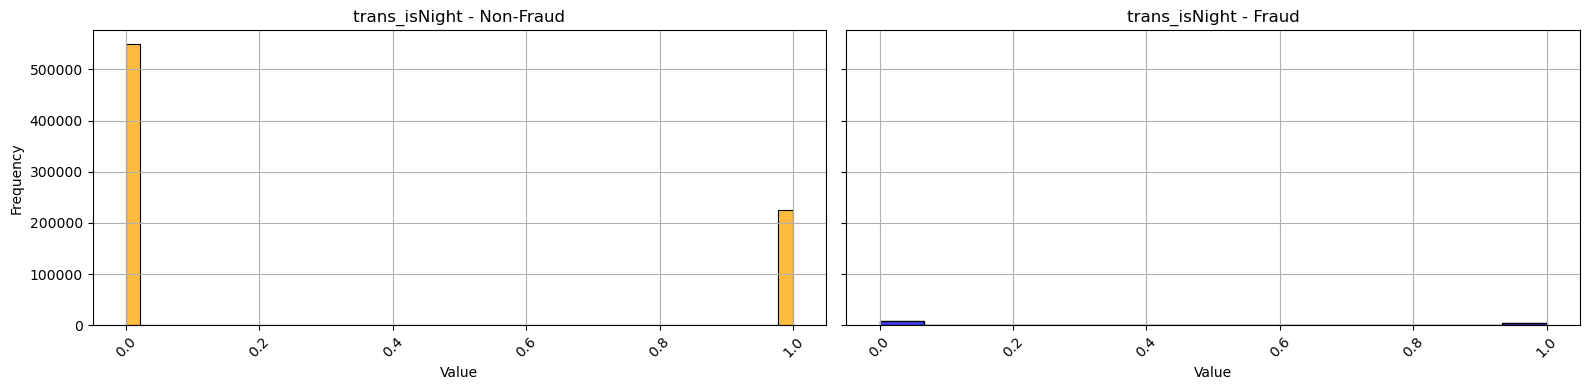

,col,cor
11,trans_isNight,1.000
1,availableMoney,0.004
0,creditLimit,0.001
16,trans_count7days,0.001
14,trans_count1days,0.001


In [88]:
hist_plt('trans_isNight')
correlation_table(data, 'trans_isNight').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_isWeekend**

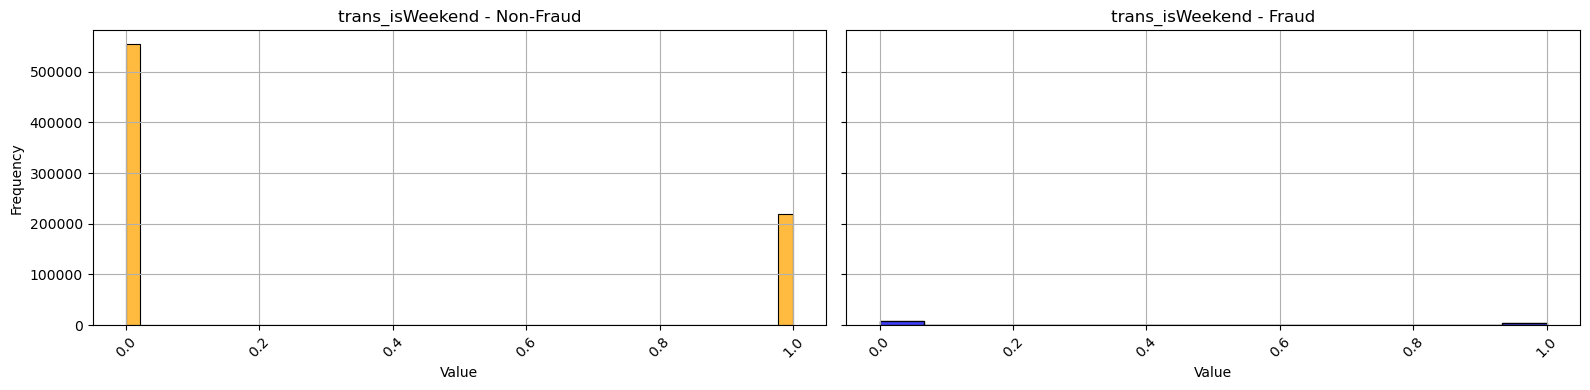

,col,cor
12,trans_isWeekend,1.000
2,transactionAmount,0.003
0,creditLimit,0.002
1,availableMoney,0.002
10,trans_hour,0.002


In [90]:
hist_plt('trans_isWeekend')
correlation_table(data, 'trans_isWeekend').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_avg1days**

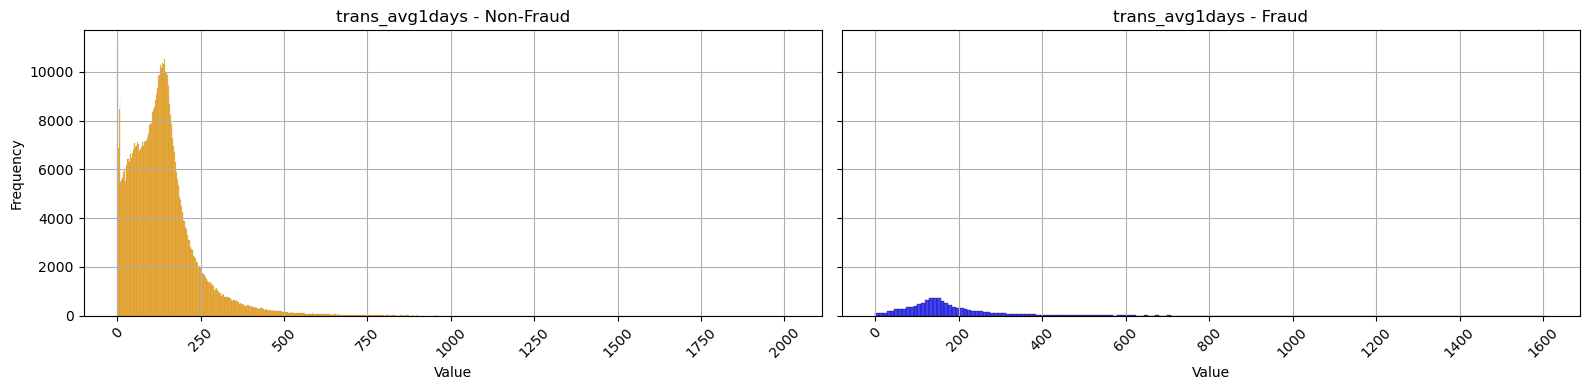

,col,cor
13,trans_avg1days,1.000
2,transactionAmount,0.660
15,trans_avg7days,0.579
14,trans_count1days,0.264
16,trans_count7days,0.262


In [92]:
hist_plt('trans_avg1days')
correlation_table(data, 'trans_avg1days').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_count1days**

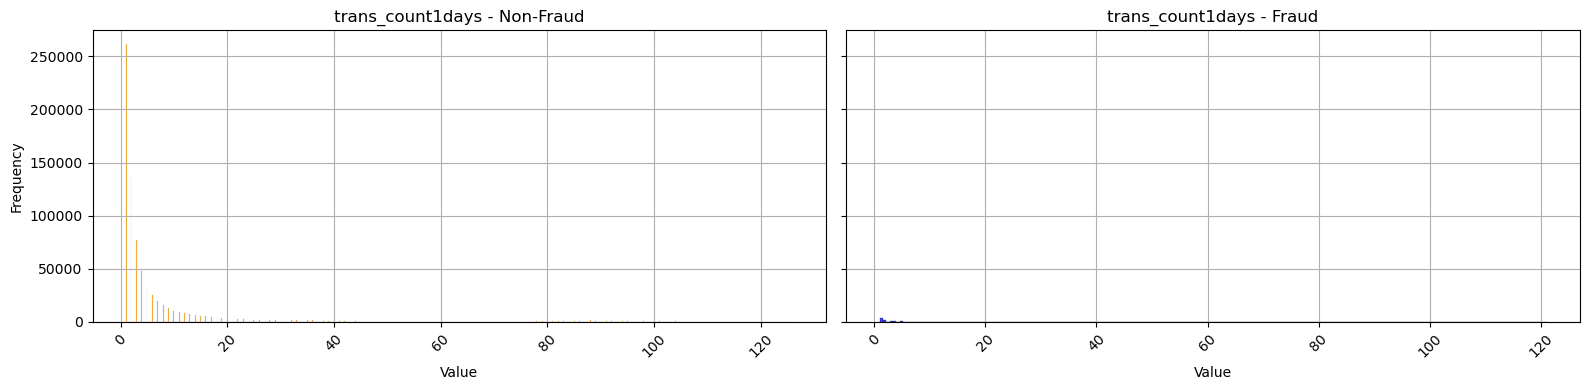

,col,cor
14,trans_count1days,1.000
16,trans_count7days,0.894
3,currentBalance,0.368
13,trans_avg1days,0.264
15,trans_avg7days,0.225


In [94]:
hist_plt('trans_count1days')
correlation_table(data, 'trans_count1days').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_avg7days**

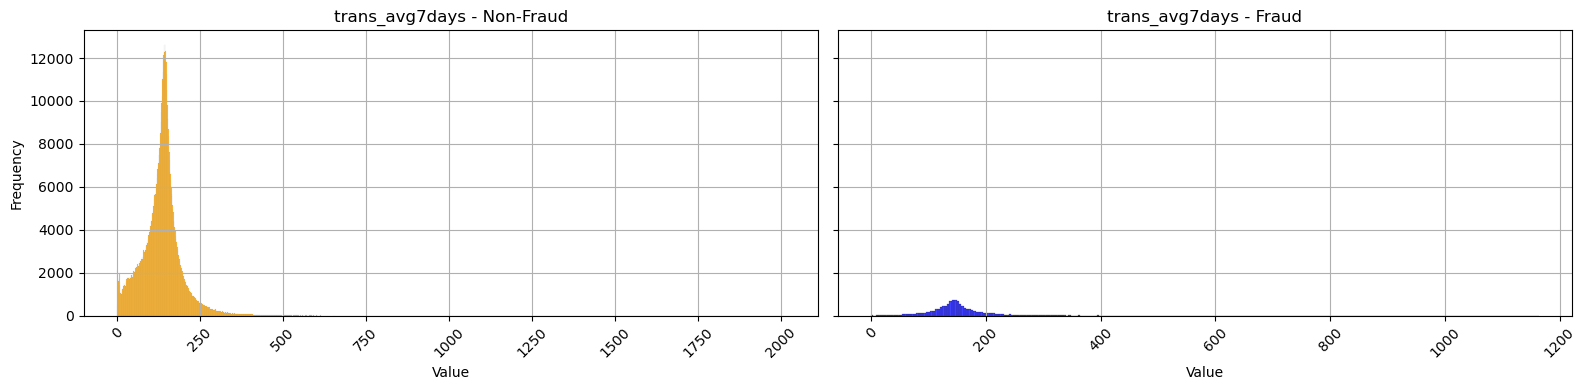

,col,cor
15,trans_avg7days,1.000
13,trans_avg1days,0.579
2,transactionAmount,0.383
16,trans_count7days,0.268
14,trans_count1days,0.225


In [96]:
hist_plt('trans_avg7days')
correlation_table(data, 'trans_avg7days').sort_values(by = ['cor'], ascending = False).head(5)

#### **trans_count7days**

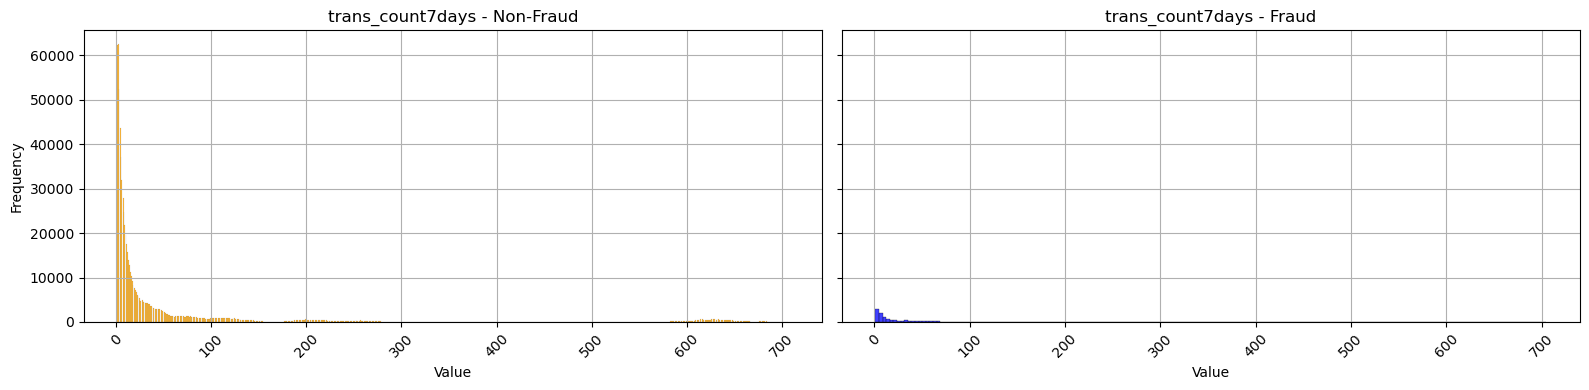

,col,cor
16,trans_count7days,1.000
14,trans_count1days,0.894
3,currentBalance,0.431
15,trans_avg7days,0.268
13,trans_avg1days,0.262


In [98]:
hist_plt('trans_count7days')
correlation_table(data, 'trans_count7days').sort_values(by = ['cor'], ascending = False).head(5)

#### **time_diff_transaction**

In [100]:
correlation_table(data, 'time_diff_transaction').sort_values(by = ['cor'], ascending = False).head(5)

,col,cor
17,time_diff_transaction,1.000
1,availableMoney,0.132
8,trans_month,0.046
9,trans_day,0.012
4,cardPresent,0.009


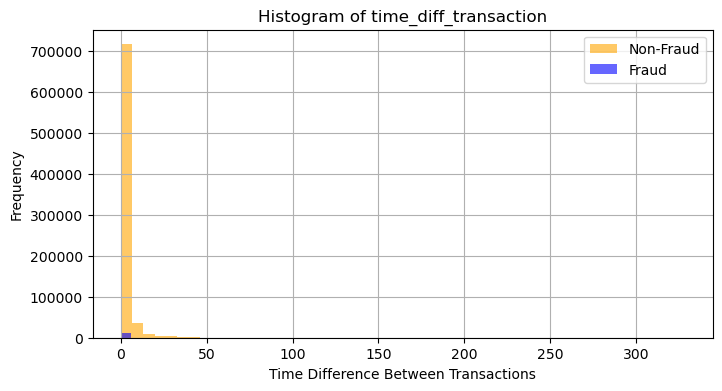

In [101]:
plt.figure(figsize=(8, 4))
plt.hist(data[data['isFraud'] == 0]['time_diff_transaction'], bins=50, color='orange', alpha=0.6, label='Non-Fraud')
plt.hist(data[data['isFraud'] == 1]['time_diff_transaction'], bins=50, color='blue', alpha=0.6, label='Fraud')
# Title and Legend
plt.title('Histogram of time_diff_transaction')
plt.xlabel('Time Difference Between Transactions')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

#### **Drop Columns that are highly correlated**

In [103]:
# columns ['trans_count7days', 'trans_count1days'] = 0.894 and ['availableMoney','creditLimit'] = 0.83
# drop columns trans_count7days & creditLimit

data = data.drop(columns = ['trans_count7days','creditLimit'], axis = 1)

In [104]:
data.describe()

,availableMoney,transactionDateTime,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvvMatch,trans_month,trans_day,trans_hour,trans_isNight,trans_isWeekend,trans_avg1days,trans_count1days,trans_avg7days,time_diff_transaction
count,786363.000000,786363,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,6250.725369,2016-07-06 01:58:58.395681280,136.985791,4508.739089,0.448734,0.001326,0.015790,0.991079,6.648343,15.732804,11.511333,0.290814,0.284342,136.997708,8.915259,137.074401,1.793181
min,-1005.630000,2016-01-01 00:01:02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1077.420000,2016-04-06 19:35:07,33.650000,689.910000,0.000000,0.000000,0.000000,1.000000,4.000000,8.000000,6.000000,0.000000,0.000000,67.330000,1.000000,104.742614,0.000000
50%,3184.860000,2016-07-08 05:03:57,87.900000,2451.760000,0.000000,0.000000,0.000000,1.000000,7.000000,16.000000,12.000000,0.000000,0.000000,124.854865,2.000000,138.343636,0.000000
75%,7500.000000,2016-10-05 13:52:03.500000,191.480000,5291.095000,1.000000,0.000000,0.000000,1.000000,10.000000,23.000000,18.000000,1.000000,1.000000,174.350000,7.000000,160.878619,1.000000
max,50000.000000,2016-12-30 23:59:45,2011.540000,47498.810000,1.000000,1.000000,1.000000,1.000000,12.000000,31.000000,23.000000,1.000000,1.000000,2011.540000,126.000000,2011.540000,328.000000
std,8880.783989,NaN,147.725569,6457.442068,0.497365,0.036395,0.124664,0.094028,3.436256,8.780564,6.921098,0.454138,0.451101,104.434205,18.776191,66.098655,6.127568


#### **create UID columns for customer and merchant**

In [106]:
# customer related columns : customerID, acqCountry, cardLast4Digit
data['customer_uid'] = data.customerId.astype(str) + '_' + data.acqCountry.astype(str) + '_' + data.cardLast4Digits.astype(str)
# merchant related columns : merchantName, merchantCountryCode, merchantCategoryCode
data['merchant_uid'] = data.merchantName.astype(str) + '_' + data.merchantCountryCode.astype(str) + '_' + data.merchantCategoryCode.astype(str)


In [107]:
data['cus_uid_transAmt_mean'] = data.groupby('customer_uid')['transactionAmount'].transform('mean')
data['cus_uid_avilMon_mean'] = data.groupby('customer_uid')['availableMoney'].transform('mean')
data['cus_uid_curBal_mean'] = data.groupby('customer_uid')['currentBalance'].transform('mean')

data['merch_uid_transAmt_mean'] = data.groupby('merchant_uid')['transactionAmount'].transform('mean')
data['merch_uid_avilMon_mean'] = data.groupby('merchant_uid')['availableMoney'].transform('mean')
data['merch_uid_curBal_mean'] = data.groupby('merchant_uid')['currentBalance'].transform('mean')

In [176]:
data = data.drop(columns = ['customerId', 'acqCountry', 'cardLast4Digits', 'merchantName', 'merchantCountryCode', 'merchantCategoryCode',
                            'customer_uid','merchant_uid', 'transactionDateTime'], axis = 1)

#### **Drop Columns with low varirance**

In [179]:
des_df = data.describe()
des_df[des_df.index == 'std']

,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,cvvMatch,trans_month,trans_day,trans_hour,trans_isNight,trans_isWeekend,trans_avg1days,trans_count1days,trans_avg7days,time_diff_transaction,cus_uid_transAmt_mean,cus_uid_avilMon_mean,cus_uid_curBal_mean,merch_uid_transAmt_mean,merch_uid_avilMon_mean,merch_uid_curBal_mean
std,8880.783989,147.725569,6457.442068,0.497365,0.036395,0.124664,0.094028,3.436256,8.780564,6.921098,0.454138,0.451101,104.434205,18.776191,66.098655,6.127568,26.022308,8311.852666,5649.52463,30.659958,1333.644566,1983.473377


In [181]:
data = data.drop(columns = ['expirationDateKeyInMatch','cvvMatch'] , axis = 1)

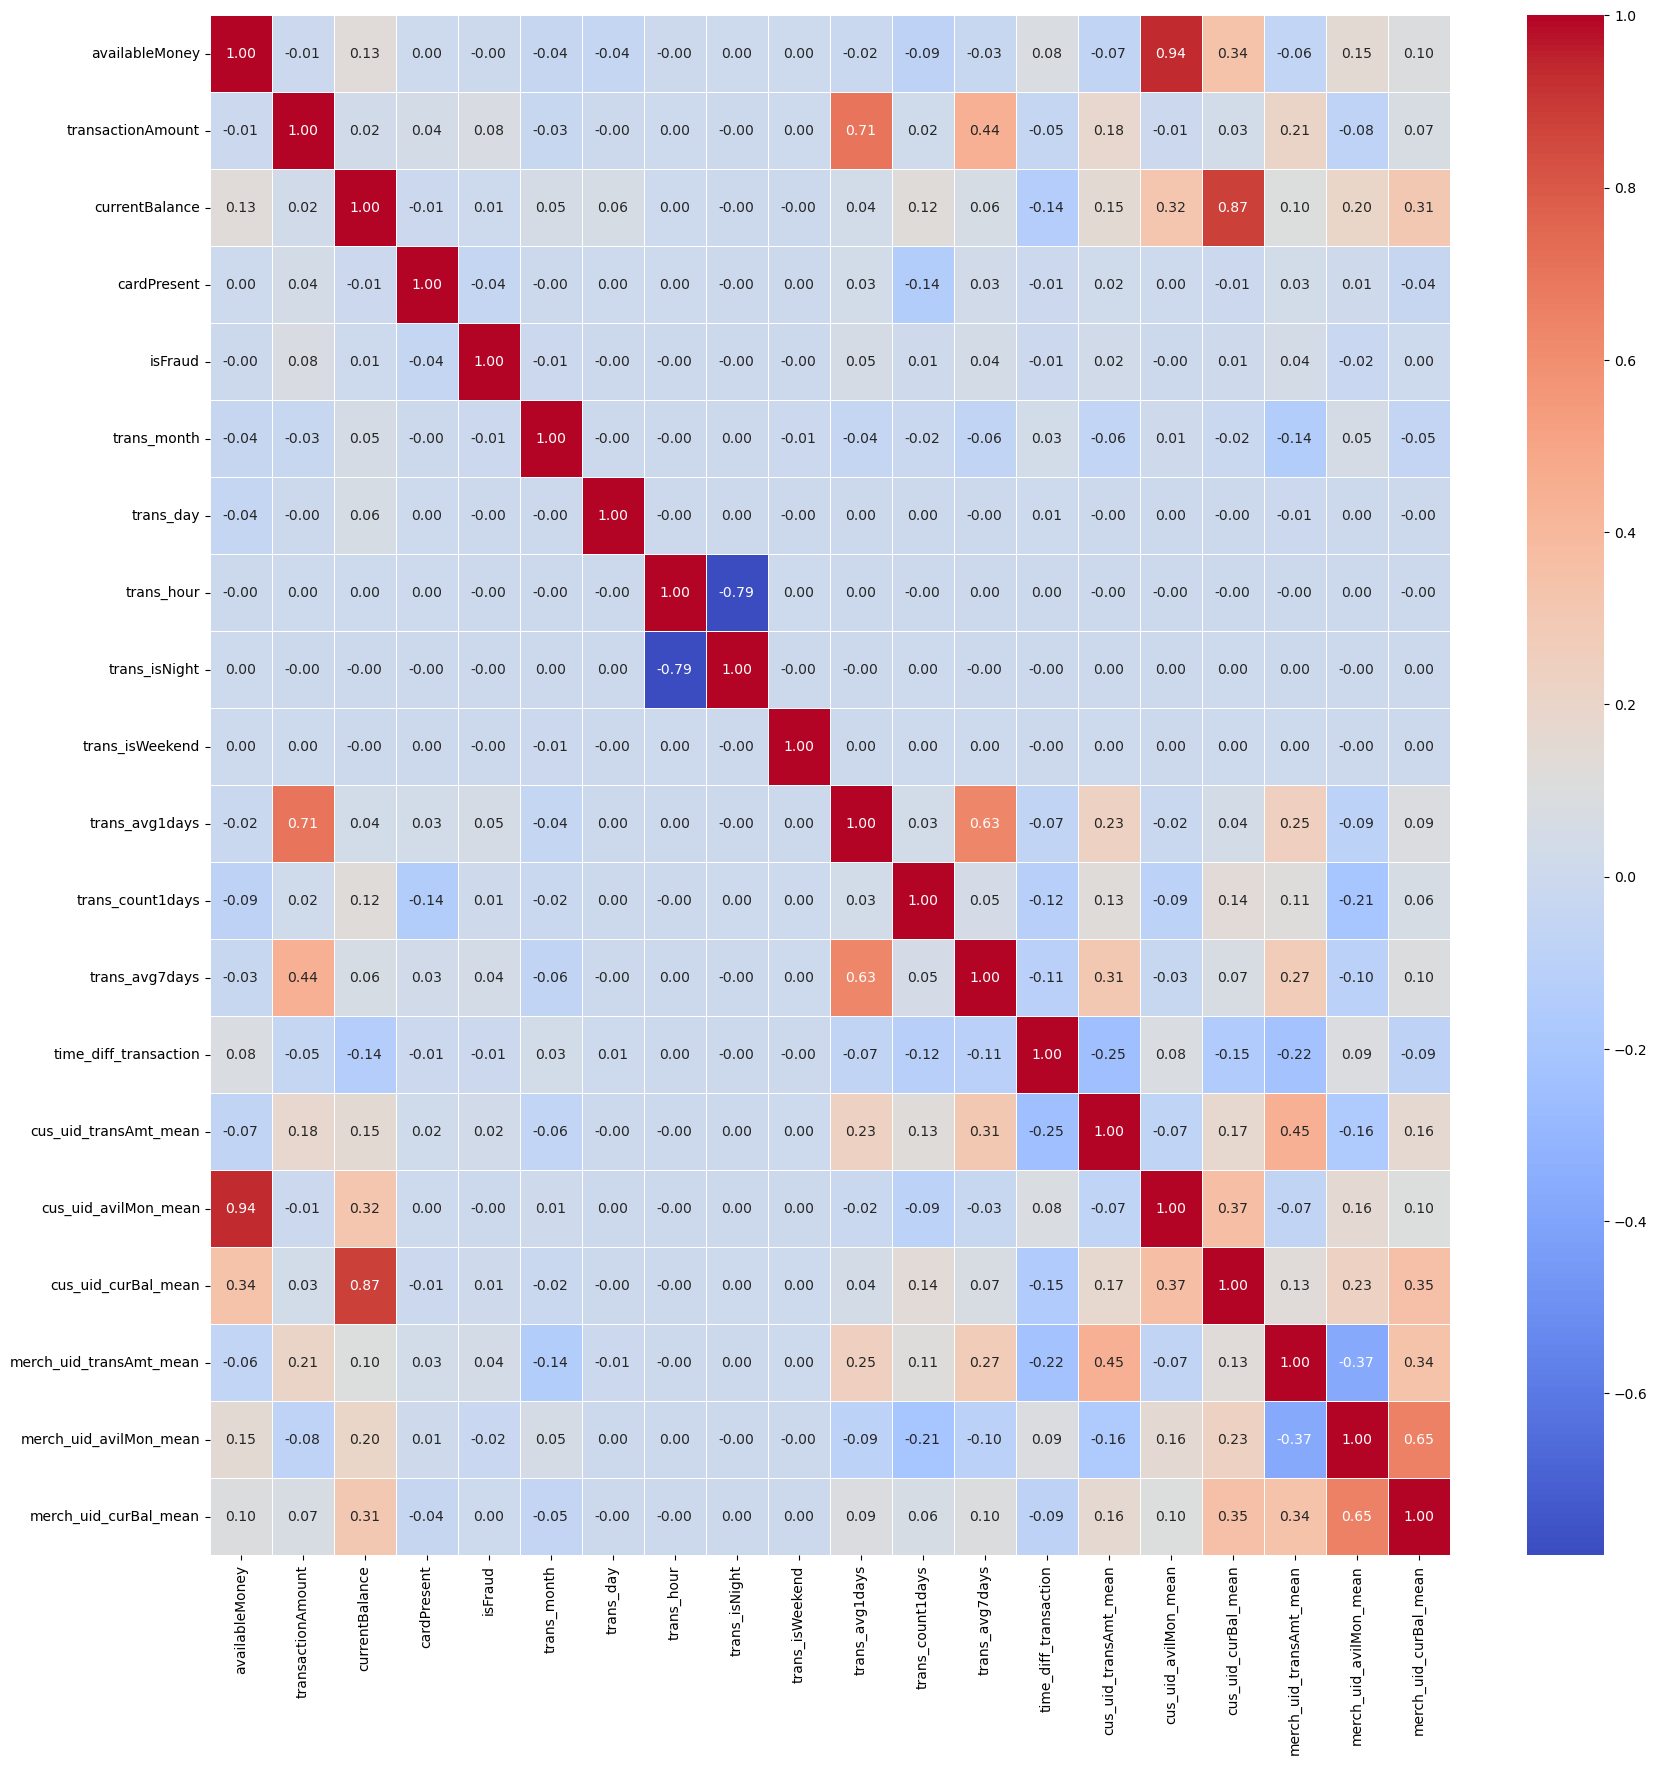

In [183]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize = (20,20))
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

In [185]:
data = data.drop(columns = ['availableMoney','currentBalance'],axis =1 )

In [187]:
data.to_csv('data.csv', index=False)